## Import all needed modules

In [ ]:
import sys
import subprocess

if 'darwin' in sys.platform:
    print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
    subprocess.Popen('caffeinate')

In [ ]:
import requests 
import string
from bs4 import BeautifulSoup  
import logging  
logging.basicConfig(level=logging.DEBUG)
import dateutil.parser
import time
import re
from collections import OrderedDict
import pandas as pd
from datetime import datetime
import numpy as np

## Get movie urls from boxofficemojo.com

In [ ]:
def get_all_movies():  
    """ returns all the movie urls from boxofficemojo.com in a list"""

    # Alphabet loop for how movies are indexed including
    # movies that start with a special character or number
    index = ["NUM"] + list(string.ascii_uppercase)

    # List of movie urls
    movies_list = []

    # Loop through the pages for each letter
    for letter in index:

        # Loop through the pages within each letter
        for num in range(1, 20):
            url = ("http://www.boxofficemojo.com/movies/alphabetical.htm?"
                   "letter=" + letter + "&page=" + str(num))
            try:
                response = requests.get(url)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                rows = soup.find(id="body").find("table").find("table").find_all(
                    "table")[1].find_all("tr")

                # skip index row
                if len(rows) > 1:
                    counter = 1
                    for row in rows:
                        # skip index row
                        if counter > 1:
                            link = row.td.font.a['href']
                            # don't add duplicates
                            if link not in movies_list:
                                movies_list.append(link)

                        counter += 1
            except (Exception, e):
                logging.exception(e)

    return movies_list

#### To get the url of the movies, call the function defined above 

In [ ]:
all_movies = get_all_movies()

## Define certain useful functions

In [ ]:
def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None


def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None



#def get_movie_value_next_next(soup, field_name):
#    '''Grab a value from boxofficemojo HTML
#    
#    Takes a string attribute of a movie on the page and
#    returns the string in the next sibling object
#    (the value for that attribute)
#    or None if nothing is found.
#    '''
#    obj = soup.find(text=re.compile(field_name))
#    
#    if obj:
#        return obj.next.next.text
#    else:
#        return None

def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)


def money_to_int_2(string):
    if string is not None:
        i = string.replace('$','').replace(',','').replace(' ','')
        if "million" in i:
            i = i.replace('million','')
            i = float(i) * 1000000
            i = int(i)
        return i
    else:
        return np.nan

def money_to_int_3(moneystring):
    moneystring = moneystring.replace('\xa0','').replace('$', '').replace(',','')
    

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def strip_and_return_int(s):
    t = s.replace('$', '').replace(',','')
    t = int(t)
    return t

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

## Define functions to get movie information

In [ ]:
def movie_title(soup):        
    #try:
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    #except:
        #title = float('NaN')
        
    return title 
    
def movie_producers(soup):
    try:
        producer = get_movie_value_next(soup, 'Producer')
        producers = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', producer).split(",") 
    except TypeError:
        producers = float('NaN')
    except AttributeError:
        producers = float('NaN')
        
    return producers
        
def movie_directors(soup):
    try:
        director = get_movie_value_next(soup,'Director')
        director = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', director).split(",") 
    except TypeError:
        director = float('NaN')
    
    return director
    

def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            return actors

    except TypeError:
        return actors

def movie_genre(soup):
    try:
        genre = get_movie_value(soup, 'Genre[^a-z]')
    except:
        genre = float('NaN')
    return genre

def movie_rating(soup):
    try:
        rating = get_movie_value(soup,'MPAA Rating')
    except:
        rating = float('NaN')
    return rating

#def release_date(soup):
#    try:
#        raw_release_date = get_movie_value(soup,'Release Date')
#        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date[0].isnumeric() :
#            release_date = to_date(raw_release_date)
#        else:
#            release_date = float('NaN')
#    except AttributeError:
#        release_date = float('NaN')
#    
#    return release_date

def release_date(soup):
    try:
        raw_release_date = get_movie_value(soup,'Release Date')
        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date.split()[0] != 'Spring' and raw_release_date.split()[0] != 'Summer' and raw_release_date.split()[0] != 'Fall' and raw_release_date.split()[0] != 'Winter' :
            release_date = to_date(raw_release_date)
        else:
            release_date = float('NaN')
    except AttributeError:
        release_date = float('NaN')
    return release_date
    
def domestic_gross(soup):
    
    try:
        raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
        domestic_total_gross = money_to_int(raw_domestic_total_gross)
    except AttributeError:
        domestic_total_gross = float('NaN')
    
    return domestic_total_gross
    
def opening_weekend_gross(soup):
    
    try:
        opening_weekend_gross = get_movie_value_next(soup,'Opening\xa0Weekend:')
        opening_weekend_gross = money_to_int_3(opening_weekend_gross)
    except AttributeError:
        opening_weekend_gross = float('NaN')
    return opening_weekend_gross
    
def production_budget(soup):
    try:
        production_budget = get_movie_value(soup, 'Production Budget')
        production_budget = money_to_int_2(production_budget)
    except AttributeError:
        production_budget = float('NaN')
    return production_budget
    
def runtime(soup):
    try:
        raw_runtime = get_movie_value(soup,'Runtime')
        runtime = runtime_to_minutes(raw_runtime)
    except AttributeError:
        runtime = float('NaN')
    return runtime
    
def widest_release(soup):
    try:
        widest_release = get_movie_value_next_next(soup, 'Widest')
        widest_release = strip_and_return_int(widest_release.split()[0])
    except AttributeError:
        widest_release = float('NaN')
    return widest_release

def distributor(soup):
    try:
        if str(soup.find(id='body')) != 'None':
            distributor = soup.find(id="body").find(text=re.compile("Distributor"))
            if str(distributor) != 'None':
                distributor = distributor.findNextSibling().text
                return distributor
    except LookupError:
        distributor = float('NaN')


## MOVIE SCRAPER

In [ ]:
def movie_scraper(all_movies):    
    movie_blocks = list(range(0, len(all_movies)-1, int(len(all_movies)/10)))
    movie_blocks.append(len(all_movies)-1) 
            
    print("The length of urls_chunks, minus one is %s" % str(len(movie_blocks)-1))
    
    movie_data_list = OrderedDict()
    count = 0 
    try:
        for block_index in range(len(movie_blocks) - 1):
                    
            print ("URL chunk ... %s of %s in 10 seconds ... \n" % (str(block_index), str(len(movie_blocks) - 1)))
            
            time.sleep(10)
            
            print ("Fetching URLs in movie_list location: %s to %s \n" % (movie_blocks[block_index], movie_blocks[block_index + 1]))
            for movie in all_movies[movie_blocks[block_index]:movie_blocks[block_index + 1]]:
                count +=1
                url = "http://www.boxofficemojo.com/" + movie
                response = requests.get(url)
                time.sleep(0.1)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                print(count,movie)
                movie_data_list[movie_title(soup)] = [movie, movie_genre(soup), release_date(soup), 
                                                        distributor(soup), runtime(soup), 
                                                        movie_rating(soup), production_budget(soup), 
                                                        domestic_gross(soup), movie_actors(soup), 
                                                        opening_weekend_gross(soup), widest_release(soup),
                                                        movie_producers(soup), movie_directors(soup) ]
                        
                
                
                #try:
                #    time.sleep(0.2)
                #    response = requests.get(url)
                #    page = response.text
                #    #print(str(re.search('\w+(?=\.htm)', url).group()))
                #    soupObjects[str(re.search('\w+(?=\.htm)',url).group())] = BeautifulSoup(page,'lxml')
                #except requests.exceptions.RequestException as e:
                #    print(e)
                #    sys.exit(1)
                #
                    
            print("continuing in 10 seconds ...")
    except requests.exceptions.RequestException as e:
        print(e)
        pass
        #sys.exit(1)
            
    return movie_data_list


## SCRAPING the data!

In [ ]:
dict_1 = movie_scraper(all_movies)

In [ ]:
df = pd.DataFrame(dict_1)

In [ ]:
df.to_pickle('001.pkl')

In [ ]:
dict_2 = movie_scraper(all_movies[1522:])

In [ ]:
df2 = pd.DataFrame(dict_2)

In [ ]:
df2.to_pickle('002.pkl')

In [ ]:
dict_3 = movie_scraper(all_movies[7200:])

In [ ]:
df3 = pd.DataFrame(dict_3)

In [ ]:
df3.to_pickle('003.pkl')

In [ ]:
dict_4 = movie_scraper(all_movies[10284:])

In [ ]:
df4 = pd.DataFrame(dict_4)

In [ ]:
df4.to_pickle('004.pkl')

In [ ]:
dict_5 = movie_scraper(all_movies[15372:])

In [ ]:
df5 = pd.DataFrame(dict_5)

In [ ]:
df5.to_pickle('005.pkl')

In [ ]:
dict_6 = movie_scraper(all_movies[15881:])

In [ ]:
df6 = pd.DataFrame(dict_6)

In [ ]:
df6.to_pickle('006.pkl')

## transpose the dfs

In [ ]:
df = df.transpose()
df2 = df2.transpose()
df3 = df3.transpose()
df4 = df4.transpose()
df5 = df5.transpose()
df6 = df6.transpose()

In [ ]:
df.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']

In [ ]:
df_all = pd.concat([df, df2, df3, df4, df5, df6])

In [ ]:
df_all.shape
df_all.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']

In [ ]:
df_all.head()

In [ ]:
df_all['title'] = df_all.index

In [ ]:
df_all.head()

In [ ]:
df_all.to_pickle('all_movies_20161003.pkl')

In [ ]:
DF = df_all.sort_values('release date')

In [ ]:
DF.index = range(len(DF))

Oldest movie in data set is from 1919.

In [ ]:
DF['release date'][0]

Select movies with release dates in 1990 and beyond.

In [ ]:
DF_90s = DF[DF['release date'] > datetime(1989, 12, 31, 0, 0)]

In [ ]:
DF_90s.to_pickle('movies_from_the_90s.pkl')

# Work: DATA EXPLORATION

### start here

In [1]:
import pandas as pd 

In [2]:
DF_90s = pd.read_pickle('movies_from_the_90s.pkl')

In [3]:
# Which columns have missing values ? 
# what percentage is missing ? 
for i in DF_90s.columns:
    print (i, (DF_90s[i].isnull().sum())/len(DF_90s))

movie 0.0
genre 0.0
release date 0.0
distributor 0.0
runtime 0.0493249565566
rating 0.0
budget 0.0
domestic gross 0.135409704585
actors 0.497460232589
1st weekend gross 1.0
widest release 0.0794679855634
producers 1.0
directors 1.0
title 0.0


In [6]:
DF_90s['actors_no_nan'] = DF_90s['actors'].fillna('')


In [7]:
DF_90s.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', '1st weekend gross',
       'widest release', 'producers', 'directors', 'title', 'actors_no_nan'],
      dtype='object')

In [8]:
DF_90s.shape

(14962, 15)

In [9]:
DF_90s = DF_90s.drop_duplicates(subset = 'movie')

In [11]:
DF_90s.shape

(12583, 15)

In [12]:
def strip_end(s):
    if s.endswith("(narrator)"):
        s = s[:-len("(narrator)")]
    elif s.endswith("(Narrator)"):
        s = s[:-len("(Narrator)")]
    elif s.endswith("(Himself)"):
        s = s[:-len("(Himself)")]
    elif s.endswith("(Herself)"):
        s = s[:-len("(Herself)")]
    return s
# test on: s = "the narrator is (narrator)"

In [13]:
def strip_one_space(s):
    """ Strips space at beginning or end of string"""
    if s.endswith(" "): s = s[:-1]
    if s.startswith(" "): s = s[1:]
    return s

In [14]:
def unnest(df, col, reset_index=False):
    """ Unnest cells of series that have lists in them."""
    import pandas as pd
    col_flat = pd.DataFrame([[i, x] 
                       for i, y in df[col].apply(list).iteritems() 
                           for x in y], columns=['I', col])
    col_flat = col_flat.set_index('I')
    df = df.drop(col, 1)
    df = df.merge(col_flat, left_index=True, right_index=True)
    if reset_index:
        df = df.reset_index(drop=True)
    return df

In [15]:
DF_90s.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', '1st weekend gross',
       'widest release', 'producers', 'directors', 'title', 'actors_no_nan'],
      dtype='object')

In [16]:
expected = unnest(DF_90s, 'actors_no_nan')

In [17]:
expected

movie               genre  \
3447            /movies/?id=internalaffairs.htm      Crime Thriller   
3447            /movies/?id=internalaffairs.htm      Crime Thriller   
3448             /movies/?id=texaschainsaw3.htm              Horror   
3451                   /movies/?id=downtown.htm       Action Comedy   
3453                    /movies/?id=tremors.htm       Horror Comedy   
3453                    /movies/?id=tremors.htm       Horror Comedy   
3455                    /movies/?id=streets.htm    Drama / Thriller   
3458             /movies/?id=heartcondition.htm      Fantasy Comedy   
3459                     /movies/?id=stella.htm               Drama   
3459                     /movies/?id=stella.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3467             /movies/?id=stanleyandiris.htm             Romance   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3474            /movies/?id=couragemountain.htm    Family Adventure   
3478              /movies/?id=bloodofheroes.htm       Sci-Fi Action   
3479          /movies/?id=wheretheheartis90.htm              Comedy   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3484                 /movies/?id=houseparty.htm              Comedy   
3487              /movies/?id=handmaidstale.htm               Drama   
...                                         ...                 ...   
18334           /movies/?id=wbeventfilm2018.htm              Horror   
18336             /movies/?id=wreckitralph2.htm           Animation   
18336             /movies/?id=wreckitralph2.htm           Animation   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18348            /movies/?id=lifeoftheparty.htm              Comedy   
18348            /movies/?id=lifeoftheparty.htm              Comedy   
18354       /movies/?id=jurassicworldsequel.htm  Action / Adventure   
18354       /movies/?id=jurassicworldsequel.htm  Action / Adventure   
18356         /movies/?id=ant-manandthewasp.htm              Action   
18356         /movies/?id=ant-manandthewasp.htm              Action   
18367            /movies/?id=junglebook2016.htm           Adventure   
18368                /movies/?id=grinch2017.htm           Animation   
18372     /movies/?id=disneyliveaction22018.htm             Musical   
18372     /movies/?id=disneyliveaction22018.htm             Musical   
18377     /movies/?id=spongebobsquarepants3.htm           Animation   
18380               /movies/?id=marvel2018a.htm  Action / Adventure   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animatio

### convert data types

In [18]:
df_converted_0 = expected.convert_objects(convert_dates = True, convert_numeric = True)

/Users/ausubo/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


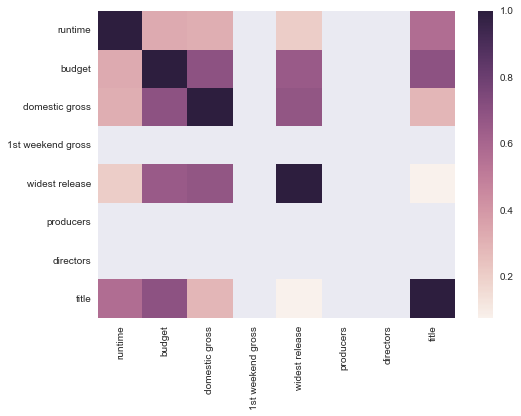

In [19]:
%matplotlib inline
import seaborn as sns
sns.heatmap(df_converted_0.corr()) # correlation matrix 

#### Strip space and things like "(narrator)" at the end of the names

In [20]:
df_converted_0['actors_no_nan_2'] = df_converted_0['actors_no_nan'].apply(strip_end).apply(strip_one_space)

In [21]:
df_converted_0.shape

(23057, 16)

In [22]:
df_converted_0.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', '1st weekend gross',
       'widest release', 'producers', 'directors', 'title', 'actors_no_nan',
       'actors_no_nan_2'],
      dtype='object')

In [23]:
del df_converted_0['actors_no_nan']
del df_converted_0['producers']
del df_converted_0['directors']
del df_converted_0['1st weekend gross']

### Genre functions: 1 or 0 

In [24]:
def comedy(s):
    if 'Comedy' in s:
        return 1
    else:
        return 0

def drama(s):
    if 'Drama' in s:
        return 1
    else:
        return 0

def animation(s):
    if 'Animation' in s:
        return 1
    else:
        return 0

def thriller(s):
    if 'Thriller' in s:
        return 1
    else:
        return 0 

def unknown(s):
    if 'Unknown' in s:
        return 1
    else:
        return 0

def action(s):
    if 'Action' in s:
        return 1
    else:
        return 0

def horror(s):
    if 'Horror' in s:
        return 1 
    else:
        return 0

def romance(s):
    if 'Romance' in s:
        return 1
    else:
        return 0

def fantasy(s):
    if 'Fantasy' in s:
        return 1
    else:
        return 0

def family(s):
    if 'Family' in s:
        return 1
    else:
        return 0

def sports(s):
    if 'Sports' in s:
        return 1
    else:
        return 0

def foreign(s):
    if 'Foreign' in s:
        return 1
    else:
        return 0

def music(s):
    if 'Music' in s:
        return 1
    elif 'Concert' in s:
        return 1
    else:
        return 0

def western(s):
    if 'Western' in s:
        return 1
    else:
        return 0

def crime(s):
    if 'Crime' in s:
        return 1
    else:
        return 0 
    
def sci_fi(s):
    if 'Sci-Fi' in s:
        return 1
    else:
        return 0

def war(s):
    if 'War' in s:
        return 1
    else:
        return 0
    
def documentary(s):
    if 'Documentary' in s:
        return 1
    else:
        return 0

In [25]:
df_converted_0['genre_comedy'] = df_converted_0['genre'].apply(comedy)
df_converted_0['genre_drama'] = df_converted_0['genre'].apply(drama)
df_converted_0['genre_animation'] = df_converted_0['genre'].apply(animation)
df_converted_0['genre_thriller'] = df_converted_0['genre'].apply(thriller)
df_converted_0['genre_unknown'] = df_converted_0['genre'].apply(unknown)
df_converted_0['genre_action'] = df_converted_0['genre'].apply(action)
df_converted_0['genre_horror'] = df_converted_0['genre'].apply(horror)
df_converted_0['genre_romance'] = df_converted_0['genre'].apply(romance)
df_converted_0['genre_fantasy'] = df_converted_0['genre'].apply(fantasy)
df_converted_0['genre_family'] = df_converted_0['genre'].apply(family)
df_converted_0['genre_sports'] = df_converted_0['genre'].apply(sports)
df_converted_0['genre_foreign'] = df_converted_0['genre'].apply(foreign)
df_converted_0['genre_music'] = df_converted_0['genre'].apply(music)
df_converted_0['genre_western'] = df_converted_0['genre'].apply(western)
df_converted_0['genre_crime'] = df_converted_0['genre'].apply(crime)
df_converted_0['genre_sci_fi'] = df_converted_0['genre'].apply(sci_fi)
df_converted_0['genre_war'] = df_converted_0['genre'].apply(war)
df_converted_0['genre_documentary'] = df_converted_0['genre'].apply(documentary)

## Rating functions: 1 or 0

In [26]:
def rating_R(s):
    if 'R' in s:
        return 1
    else:
        return 0

def rating_PG_13(s):
    if s == 'PG-13':
        return 1
    else:
        return 0

def rating_PG(s):
    if s == 'PG':
        return 1
    else:
        return 0
    
def unrated(s):
    if 'Unrated' in s:
        return 1
    else:
        return 0

def not_yet_rated(s):
    if 'Not Yet Rated' in s:
        return 1
    else:
        return 0

def rating_G(s):
    if s == 'G':
        return 1
    else:
        return 0

def unknown(s):
    if 'Unknown' in s:
        return 1
    else:
        return 0

def rating_NC_17(s):
    if 'NC-17' in s:
        return 1
    else:
        return 0

In [27]:
df_converted_0['rating R'] = df_converted_0['rating'].apply(rating_R)
df_converted_0['rating PG13'] = df_converted_0['rating'].apply(rating_PG_13)
df_converted_0['rating PG'] = df_converted_0['rating'].apply(rating_PG)
df_converted_0['unrated'] = df_converted_0['rating'].apply(unrated)
df_converted_0['not yet rated'] = df_converted_0['rating'].apply(not_yet_rated)
df_converted_0['rating G'] = df_converted_0['rating'].apply(rating_G)
df_converted_0['unknown'] = df_converted_0['rating'].apply(unknown)
df_converted_0['rating NC17'] = df_converted_0['rating'].apply(rating_NC_17)

In [28]:
df_converted_0 = df_converted_0.convert_objects(convert_dates = True, convert_numeric = True)

/Users/ausubo/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [29]:
df_converted_0.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', 'widest release', 'title',
       'actors_no_nan_2', 'genre_comedy', 'genre_drama', 'genre_animation',
       'genre_thriller', 'genre_unknown', 'genre_action', 'genre_horror',
       'genre_romance', 'genre_fantasy', 'genre_family', 'genre_sports',
       'genre_foreign', 'genre_music', 'genre_western', 'genre_crime',
       'genre_sci_fi', 'genre_war', 'genre_documentary', 'rating R',
       'rating PG13', 'rating PG', 'unrated', 'not yet rated', 'rating G',
       'unknown', 'rating NC17'],
      dtype='object')

In [30]:
df_converted_0['$ in per minute'] = df_converted_0['budget']/df_converted_0['runtime']
df_converted_0['$ out per minute'] = df_converted_0['domestic gross']/df_converted_0['runtime']
df_converted_0['margin'] = df_converted_0['domestic gross']/df_converted_0['budget']

In [31]:
df_converted_0.shape

(23057, 41)

In [32]:
df_converted_0.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', 'widest release', 'title',
       'actors_no_nan_2', 'genre_comedy', 'genre_drama', 'genre_animation',
       'genre_thriller', 'genre_unknown', 'genre_action', 'genre_horror',
       'genre_romance', 'genre_fantasy', 'genre_family', 'genre_sports',
       'genre_foreign', 'genre_music', 'genre_western', 'genre_crime',
       'genre_sci_fi', 'genre_war', 'genre_documentary', 'rating R',
       'rating PG13', 'rating PG', 'unrated', 'not yet rated', 'rating G',
       'unknown', 'rating NC17', '$ in per minute', '$ out per minute',
       'margin'],
      dtype='object')

In [33]:
df_converted_1 = df_converted_0.drop(['title','genre_foreign', 'unknown','not yet rated', 'rating NC17'], axis =1 )

In [34]:
df_converted_1 # with NaNs

movie               genre  \
3447            /movies/?id=internalaffairs.htm      Crime Thriller   
3447            /movies/?id=internalaffairs.htm      Crime Thriller   
3448             /movies/?id=texaschainsaw3.htm              Horror   
3451                   /movies/?id=downtown.htm       Action Comedy   
3453                    /movies/?id=tremors.htm       Horror Comedy   
3453                    /movies/?id=tremors.htm       Horror Comedy   
3455                    /movies/?id=streets.htm    Drama / Thriller   
3458             /movies/?id=heartcondition.htm      Fantasy Comedy   
3459                     /movies/?id=stella.htm               Drama   
3459                     /movies/?id=stella.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3461               /movies/?id=mendontleave.htm               Drama   
3467             /movies/?id=stanleyandiris.htm             Romance   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3470                   /movies/?id=madhouse.htm              Comedy   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3472                    /movies/?id=revenge.htm   Romantic Thriller   
3474            /movies/?id=couragemountain.htm    Family Adventure   
3478              /movies/?id=bloodofheroes.htm       Sci-Fi Action   
3479          /movies/?id=wheretheheartis90.htm              Comedy   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3482          /movies/?id=huntforredoctober.htm     Action Thriller   
3484                 /movies/?id=houseparty.htm              Comedy   
3487              /movies/?id=handmaidstale.htm               Drama   
...                                         ...                 ...   
18334           /movies/?id=wbeventfilm2018.htm              Horror   
18336             /movies/?id=wreckitralph2.htm           Animation   
18336             /movies/?id=wreckitralph2.htm           Animation   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18341            /movies/?id=readyplayerone.htm              Sci-Fi   
18348            /movies/?id=lifeoftheparty.htm              Comedy   
18348            /movies/?id=lifeoftheparty.htm              Comedy   
18354       /movies/?id=jurassicworldsequel.htm  Action / Adventure   
18354       /movies/?id=jurassicworldsequel.htm  Action / Adventure   
18356         /movies/?id=ant-manandthewasp.htm              Action   
18356         /movies/?id=ant-manandthewasp.htm              Action   
18367            /movies/?id=junglebook2016.htm           Adventure   
18368                /movies/?id=grinch2017.htm           Animation   
18372     /movies/?id=disneyliveaction22018.htm             Musical   
18372     /movies/?id=disneyliveaction22018.htm             Musical   
18377     /movies/?id=spongebobsquarepants3.htm           Animation   
18380               /movies/?id=marvel2018a.htm  Action / Adventure   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animation   
18382             /movies/?id=amusementpark.htm           Animatio

In [35]:
# Which columns have missing values ? 
# what percentage is missing ? 
for i in df_converted_1.columns:
    print (i, (df_converted_1[i].isnull().sum())/len(df_converted_1))

movie 0.0
genre 0.0
release date 0.0
distributor 0.0
runtime 0.0274537016958
rating 0.0
budget 0.512122132107
domestic gross 0.0745977360455
actors 0.0
widest release 0.0514811120267
actors_no_nan_2 0.0
genre_comedy 0.0
genre_drama 0.0
genre_animation 0.0
genre_thriller 0.0
genre_unknown 0.0
genre_action 0.0
genre_horror 0.0
genre_romance 0.0
genre_fantasy 0.0
genre_family 0.0
genre_sports 0.0
genre_music 0.0
genre_western 0.0
genre_crime 0.0
genre_sci_fi 0.0
genre_war 0.0
genre_documentary 0.0
rating R 0.0
rating PG13 0.0
rating PG 0.0
unrated 0.0
rating G 0.0
$ in per minute 0.51303291842
$ out per minute 0.0789781844993
margin 0.520102355033


Drop rows that have NaN values in widest release, domestic gross, and runtime columns.

In [39]:
df_converted_2 = df_converted_1.dropna(axis = 0, subset = ['widest release', 'domestic gross', 'runtime'])

In [40]:
df_converted_2.shape

(21083, 36)

In [41]:
# Which columns have missing values ? 
# what percentage is missing ? 
for i in df_converted_2.columns:
    print (i, (df_converted_2[i].isnull().sum())/len(df_converted_2))

movie 0.0
genre 0.0
release date 0.0
distributor 0.0
runtime 0.0
rating 0.0
budget 0.476307925817
domestic gross 0.0
actors 0.0
widest release 0.0
actors_no_nan_2 0.0
genre_comedy 0.0
genre_drama 0.0
genre_animation 0.0
genre_thriller 0.0
genre_unknown 0.0
genre_action 0.0
genre_horror 0.0
genre_romance 0.0
genre_fantasy 0.0
genre_family 0.0
genre_sports 0.0
genre_music 0.0
genre_western 0.0
genre_crime 0.0
genre_sci_fi 0.0
genre_war 0.0
genre_documentary 0.0
rating R 0.0
rating PG13 0.0
rating PG 0.0
unrated 0.0
rating G 0.0
$ in per minute 0.476307925817
$ out per minute 0.0
margin 0.476307925817


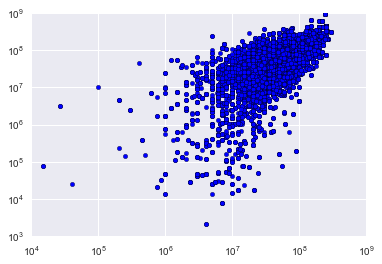

In [51]:
plt.scatter(df_converted_2['budget'], df_converted_2['domestic gross'])
plt.xscale('log')
plt.yscale('log')

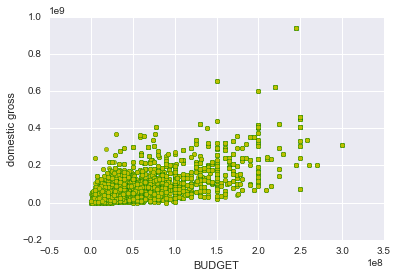

In [140]:
plt.scatter(df_converted_2['budget'], df_converted_2['domestic gross'], c = 'y', edgecolor = 'g')
plt.xlabel('BUDGET')
plt.ylabel('domestic gross')

In [52]:
df_converted_3 = df_converted_2.copy()

In [53]:
df_converted_3.columns

Index(['movie', 'genre', 'release date', 'distributor', 'runtime', 'rating',
       'budget', 'domestic gross', 'actors', 'widest release',
       'actors_no_nan_2', 'genre_comedy', 'genre_drama', 'genre_animation',
       'genre_thriller', 'genre_unknown', 'genre_action', 'genre_horror',
       'genre_romance', 'genre_fantasy', 'genre_family', 'genre_sports',
       'genre_music', 'genre_western', 'genre_crime', 'genre_sci_fi',
       'genre_war', 'genre_documentary', 'rating R', 'rating PG13',
       'rating PG', 'unrated', 'rating G', '$ in per minute',
       '$ out per minute', 'margin'],
      dtype='object')

### Drop columns that have lots of NaN values

In [54]:
del df_converted_3['$ in per minute']
del df_converted_3['margin']
del df_converted_3['budget']

In [55]:
df_converted_3.shape

(21083, 33)

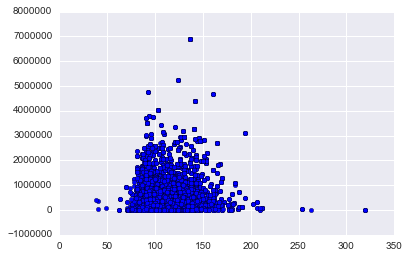

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df_converted_3['runtime'], df_converted_3['$ out per minute'])

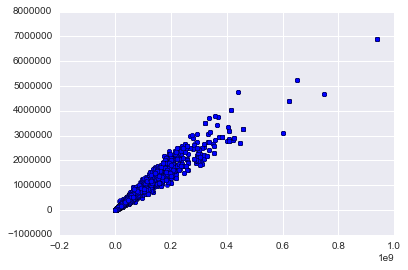

In [64]:
plt.scatter(df_converted_3['domestic gross'], df_converted_3['$ out per minute'])

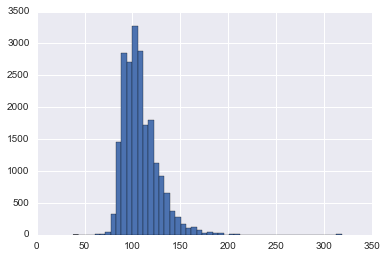

In [66]:
df_converted_3['runtime'].hist(bins = 50)

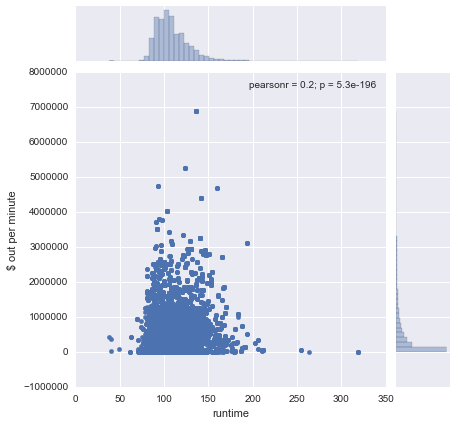

In [71]:
sns.jointplot('runtime', '$ out per minute', df_converted_3)

### Dummy variables for season

In [72]:
df_converted_3['month'] = df_converted_3['release date'].map(lambda x: x.month)

In [73]:
def holidays(month):
    if month == 11 or month == 12 or month == 1:
        return 1
    else:
        return 0

def summer(month):
    if month == 5 or month == 6 or month == 7 or month == 8 or month == 9:
        return 1
    else:
        return 0

In [74]:
df_converted_3['holidays']  = df_converted_3['month'].apply(holidays)
df_converted_3['summer'] = df_converted_3['month'].apply(summer)

In [76]:
del df_converted_3['month']


In [78]:
df_converted_4 = df_converted_3.copy()
del df_converted_4['$ out per minute']

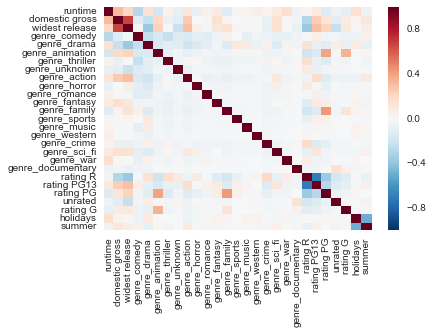

In [80]:
sns.heatmap(df_converted_4.corr())

In [81]:
#def top_grossers(a):
#    top_grossers = ['Alan Rickman', 'Amy Adams', 'Amy Poehler', 'Anna Kendrick', 
#                    'Anne Hathaway', 'Bill Hader', 'Billy Burke', 'Bonnie Hunt', 
#                    'Bradley Cooper', 'Bryce Dallas Howard', 'Cameron Diaz', 
#                    'Chris Evans', 'Chris Hemsworth', 'Chris Pine', 'Chris Pratt', 
#                    'Clark Gregg', 'Dakota Fanning', 'Diane Lane', 'Djimon Hounsou', 
#                    'Don Cheadle', 'Donald Sutherland', 'Dwayne Johnson', 'Ed Helms', 
#                    'Eddie Murphy', 'Elizabeth Banks', 'Famke Janssen', 'Gary Oldman', 
#                    'Geoffrey Rush', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 
#                    'Helena Bonham Carter', 'Hugh Jackman', 'Ian McKellen', 'Ian McShane', 
#                    'James Franco', 'Jane Lynch', 'Jeff Goldblum', 'Jena Malone', 
#                    'Jennifer Lawrence', 'Jeremy Renner', 'Joey King', 'John Cleese', 
#                    'Johnny Depp', 'Jon Favreau', 'Jon Hamm', 'Jonah Hill', 
#                    'Jonathan Pryce', 'Josh Duhamel', 'Josh Hutcherson', 
#                    'Judy Greer', 'Ken Jeong', 'Kevin James', 'Kristen Stewart', 
#                    'Kristen Wiig', 'Laurence Fishburne', 'Leonardo DiCaprio', 
#                    'Marion Cotillard', 'Mark Ruffalo', 'Maya Rudolph', 'Michael Keaton', 
#                    'Michael Sheen', 'Michelle Rodriguez', 'Mike Myers', 'Nicholas Hoult', 
#                    'Patrick Stewart', 'Paul Bettany', 'Paul Walker', 'Ray Winstone', 
#                    'Rob Riggle', 'Robert Downey', 'Samuel L. Jackson', 
#                    'Scarlett Johansson', 'Shia LaBeouf', 'Simon Pegg', 
#                    'Stanley Tucci', 'Stellan Skarsgard', 'Steve Carell', 
#                    'Steve Coogan', 'Tobey Maguire', 'Tom Cruise', 'Tom Hanks', 
#                    'Tom Hardy', 'Tommy Lee Jones', 'Topher Grace', 'Tyrese Gibson', 
#                    'Vin Diesel', 'Warwick Davis', 'Will Arnett', 'Will Smith']
#    
#    if a in top_grossers:
#        return 1
#    else:
#        return 0

In [ ]:
#df_converted_2['top grosser'] = df_converted_2['actors_no_nan_2'].apply(top_grossers)

In [82]:
df_converted_4['count'] = 1

In [126]:
df_converted_4

movie               genre  \
3447              /movies/?id=internalaffairs.htm      Crime Thriller   
3447              /movies/?id=internalaffairs.htm      Crime Thriller   
3448               /movies/?id=texaschainsaw3.htm              Horror   
3451                     /movies/?id=downtown.htm       Action Comedy   
3453                      /movies/?id=tremors.htm       Horror Comedy   
3453                      /movies/?id=tremors.htm       Horror Comedy   
3455                      /movies/?id=streets.htm    Drama / Thriller   
3458               /movies/?id=heartcondition.htm      Fantasy Comedy   
3459                       /movies/?id=stella.htm               Drama   
3459                       /movies/?id=stella.htm               Drama   
3461                 /movies/?id=mendontleave.htm               Drama   
3461                 /movies/?id=mendontleave.htm               Drama   
3461                 /movies/?id=mendontleave.htm               Drama   
3467               /movies/?id=stanleyandiris.htm             Romance   
3470                     /movies/?id=madhouse.htm              Comedy   
3470                     /movies/?id=madhouse.htm              Comedy   
3470                     /movies/?id=madhouse.htm              Comedy   
3470                     /movies/?id=madhouse.htm              Comedy   
3472                      /movies/?id=revenge.htm   Romantic Thriller   
3472                      /movies/?id=revenge.htm   Romantic Thriller   
3472                      /movies/?id=revenge.htm   Romantic Thriller   
3472                      /movies/?id=revenge.htm   Romantic Thriller   
3474              /movies/?id=couragemountain.htm    Family Adventure   
3478                /movies/?id=bloodofheroes.htm       Sci-Fi Action   
3479            /movies/?id=wheretheheartis90.htm              Comedy   
3482            /movies/?id=huntforredoctober.htm     Action Thriller   
3482            /movies/?id=huntforredoctober.htm     Action Thriller   
3482            /movies/?id=huntforredoctober.htm     Action Thriller   
3484                   /movies/?id=houseparty.htm              Comedy   
3487                /movies/?id=handmaidstale.htm               Drama   
...                                           ...                 ...   
17796            /movies/?id=freestateofjones.htm        Action Drama   
17797                /movies/?id=theneondemon.htm     Horror Thriller   
17797                /movies/?id=theneondemon.htm     Horror Thriller   
17797                /movies/?id=theneondemon.htm     Horror Thriller   
17797                /movies/?id=theneondemon.htm     Horror Thriller   
17797                /movies/?id=theneondemon.htm     Horror Thriller   
17806                      /movies/?id=purge3.htm            Thriller   
17812                  /movies/?id=tarzan2016.htm  Action / Adventure   
17812                  /movies/?id=tarzan2016.htm  Action / Adventure   
17812                  /movies/?id=tarzan2016.htm  Action / Adventure   
17812                  /movies/?id=tarzan2016.htm  Action / Adventure   
17812                  /movies/?id=tarzan2016.htm  Action / Adventure   
17818                      /movies/?id=sultan.htm               Drama   
17845                      /movies/?id=equals.htm               Drama   
17845                      /movies/?id=equals.htm               Drama   
17845                      /movies/?id=equals.htm               Drama   
17845                      /movies/?id=equals.htm               Drama   
17856                 /movies/?id=newline0116.htm              Horror   
17856                 /movies/?id=newline0116.htm              Horror   
17856                 /movies/?id=newline0116.htm              Horror   
17862  /movies/?id=absolutelyfabulousthemovie.htm              Comedy   
17867           /movies/?id=batmankillingjoke.htm           Animation   
17867           /movies/?id=batmankillingjoke.htm           Animation   
17876                /movies/

# Try cumulative \$ the author has made 


In [129]:
df_converted_4.sort_values(by=['actors_no_nan_2','release date']).groupby('actors_no_nan_2').max()

movie  \
actors_no_nan_2                                                          
""Stone Cold"" Steve Austin                /movies/?id=package2013.htm   
50 Cent                                         /movies/?id=twelve.htm   
A.J. Cook                                   /movies/?id=imreedfish.htm   
Aaron Eckhart                  /movies/?id=yourfriendsandneighbors.htm   
Aaron Johnson                          /movies/?id=shanghaiknights.htm   
Aaron Paul                                  /movies/?id=triplenine.htm   
Aaron Stanford                          /movies/?id=wintersolstice.htm   
Aasif Mandvi                               /movies/?id=premiumrush.htm   
Abbie Cornish                                /movies/?id=wemadonna.htm   
Abel Ferrara                         /movies/?id=chelseaontherocks.htm   
Abigail Breslin                             /movies/?id=zombieland.htm   
Adam Beach                                 /movies/?id=windtalkers.htm   
Adam Brody                          /movies/?id=thankyouforsmoking.htm   
Adam Carolla                                    /movies/?id=hammer.htm   
Adam DeVine                              /movies/?id=pitchperfect2.htm   
Adam Driver                             /movies/?id=whilewereyoung.htm   
Adam Goldberg                                 /movies/?id=untitled.htm   
Adam Pally                                /movies/?id=slowlearners.htm   
Adam Rodriguez                               /movies/?id=magicmike.htm   
Adam Sandler                                 /movies/?id=zookeeper.htm   
Adam Scott                              /movies/?id=whiteybulger15.htm   
Adelaide Clemens                           /movies/?id=silenthill2.htm   
Adrian Dunbar                          /movies/?id=eyeofthedolphin.htm   
Adrian Lester                                 /movies/?id=doomsday.htm   
Adriana Barraza                        /movies/?id=frompradatonada.htm   
Adrianne Palicki                             /movies/?id=reddawn10.htm   
Adrien Brody                                   /movies/?id=wrecked.htm   
Adrien Grenier                      /movies/?id=sexdeathandbowling.htm   
Adrienne Shelly                               /movies/?id=waitress.htm   
Agnes Bruckner                               /movies/?id=dreamland.htm   
...                                                                ...   
Willie Jewell                                 /movies/?id=richhill.htm   
Willie Nelson                                 /movies/?id=garden09.htm   
Wilmer Valderrama                  /movies/?id=unaccompaniedminors.htm   
Wilson Cruz                                 /movies/?id=coffeedate.htm   
Winona Ryder                 /movies/?id=welcomehomeroxycarmichael.htm   
Wood Harris                            /movies/?id=heartspecialist.htm   
Woody Allen                            /movies/?id=smalltimecrooks.htm   
Woody Harrelson                             /movies/?id=zombieland.htm   
Xavier Samuel                                    /movies/?id=plush.htm   
Yael Abecassis                       /movies/?id=aborrowedidentity.htm   
Yasmin Paige                                 /movies/?id=submarine.htm   
Yaya DaCosta                              /movies/?id=honeydripper.htm   
Yeardley Smith                                /movies/?id=simpsons.htm   
Yves Montand                                       /movies/?id=z09.htm   
Yvonne Strahovski                       /movies/?id=mymotherscurse.htm   
Zac Efron                             /movies/?id=weareyourfriends.htm   
Zach Braff                                /movies/?id=wishiwashere.htm   
Zach Cregger                                 /movies/?id=missmarch.htm   
Zach Galifianakis                        /movies/?id=youthinrevolt.htm   
Zach Gilford                                    /movies/?id=purge2.htm   
Zachary Gordon                             /movies/?id=madagascar2.htm   
Zachary Levi                                     /movies/?id=thor2.ht

In [132]:
actor_min = df_converted_4.groupby('actors_no_nan_2').min()

In [133]:
actor_max = df_converted_4.groupby('actors_no_nan_2').max()

In [134]:
actor_min['min Year'] = actor_min['release date'].map(lambda x: x.year)
actor_max['max Year'] = actor_max['release date'].map(lambda x: x.year)


In [135]:
actor_max.shape

(2444, 35)

In [136]:
actor_min.to_pickle('actor_min.pkl')
actor_max.to_pickle('actor_max.pkl')

### Group by movie

In [83]:
df_by_movie_mean = df_converted_4.groupby('movie').mean().reset_index()

In [85]:
df_by_movie_sum = df_converted_4.groupby('movie').sum().reset_index()

In [86]:
df_by_movie_mean.head()

movie  runtime  domestic gross  widest release  \
0        /movies/?id=10000bc.htm    109.0      94784201.0          3454.0   
1         /movies/?id=1000ae.htm    100.0      60522097.0          3401.0   
2      /movies/?id=1000times.htm    117.0         53895.0            24.0   
3        /movies/?id=100foot.htm    122.0      54240821.0          2167.0   
4  /movies/?id=102dalmatians.htm    104.0      66957026.0          2704.0   

   genre_comedy  genre_drama  genre_animation  genre_thriller  genre_unknown  \
0             0            0                0               0              0   
1             0            0                0               0              0   
2             0            0                0               0              0   
3             0            1                0               0              0   
4             1            0                0               0              0   

   genre_action  ...    genre_war  genre_documentary  rating R  rating PG13  \
0             0  ...            0                  0         0            1   
1             0  ...            0                  0         0            1   
2             0  ...            0                  0         0            0   
3             0  ...            0                  0         0            0   
4             0  ...            0                  0         0            0   

   rating PG  unrated  rating G  holidays  summer  count  
0          0        0         0         0       0      1  
1          0        0         0         0       1      1  
2          0        1         0         0       0      1  
3          1        0         0         0       1      1  
4          0        0         1         1       0      1  

[5 rows x 29 columns]

In [87]:
df_by_movie_sum.head()

movie  runtime  domestic gross  widest release  \
0        /movies/?id=10000bc.htm    218.0     189568402.0          6908.0   
1         /movies/?id=1000ae.htm    300.0     181566291.0         10203.0   
2      /movies/?id=1000times.htm    234.0        107790.0            48.0   
3        /movies/?id=100foot.htm    244.0     108481642.0          4334.0   
4  /movies/?id=102dalmatians.htm    312.0     200871078.0          8112.0   

   genre_comedy  genre_drama  genre_animation  genre_thriller  genre_unknown  \
0             0            0                0               0              0   
1             0            0                0               0              0   
2             0            0                0               0              0   
3             0            2                0               0              0   
4             3            0                0               0              0   

   genre_action  ...    genre_war  genre_documentary  rating R  rating PG13  \
0             0  ...            0                  0         0            2   
1             0  ...            0                  0         0            3   
2             0  ...            0                  0         0            0   
3             0  ...            0                  0         0            0   
4             0  ...            0                  0         0            0   

   rating PG  unrated  rating G  holidays  summer  count  
0          0        0         0         0       0      2  
1          0        0         0         0       3      3  
2          0        2         0         0       0      2  
3          2        0         0         0       2      2  
4          0        0         3         3       0      3  

[5 rows x 29 columns]

In [89]:
df_by_actor_sum = df_converted_4.groupby('actors_no_nan_2').sum().reset_index()
df_by_actor_mean = df_converted_4.groupby('actors_no_nan_2').mean().reset_index()

In [93]:
df_by_actor_mean['movie counts'] = df_by_actor_sum['count']

In [95]:
del df_by_actor_mean['count']

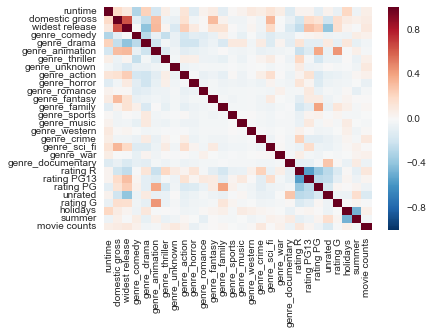

In [101]:
sns.heatmap(df_by_actor_mean.corr())

In [102]:
df_actors = df_by_actor_mean.copy()

In [103]:
del df_actors['unrated']

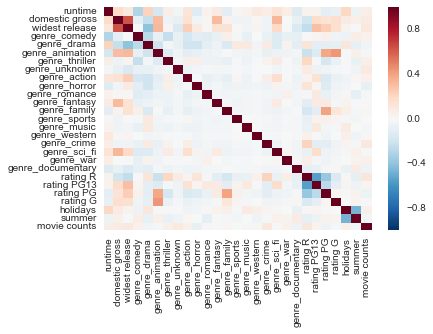

In [104]:
sns.heatmap(df_actors.corr())

In [109]:
df_by_actor_sum.to_pickle('data_actors_sum.pkl')

In [113]:
df_actors['gross overall'] = df_by_actor_sum['domestic gross']
df_actors.tail(15)

actors_no_nan_2     runtime  domestic gross  widest release  \
2429          Zac Efron  100.250000    4.735202e+07     2201.562500   
2430         Zach Braff  102.000000    4.761493e+07     1324.111111   
2431       Zach Cregger   90.000000    4.543320e+06     1742.000000   
2432  Zach Galifianakis  102.500000    7.714240e+07     2314.722222   
2433       Zach Gilford   96.000000    4.389213e+07     2700.000000   
2434     Zachary Gordon  100.428571    6.978609e+07     2856.857143   
2435       Zachary Levi   98.000000    1.407956e+08     3218.200000   
2436     Zachary Quinto  112.000000    1.056683e+08     2888.600000   
2437    Zana Marjanovic  127.000000    3.038770e+05       18.000000   
2438         Zhang Ziyi  114.800000    4.863247e+07     1201.700000   
2439           Zoe Bell  167.000000    5.411742e+07     2938.000000   
2440          Zoe Kazan  104.928571    1.456113e+07      795.285714   
2441        Zoe Saldana  108.692308    9.292556e+07     2016.461538   
2442        Zoey Deutch  103.000000    2.169255e+07     2794.000000   
2443    Zooey Deschanel  100.565217    3.345962e+07     1825.956522   

      genre_comedy  genre_drama  genre_animation  genre_thriller  \
2429      0.375000     0.312500         0.062500        0.062500   
2430      0.555556     0.222222         0.111111        0.111111   
2431      1.000000     0.000000         0.000000        0.000000   
2432      0.777778     0.166667         0.000000        0.000000   
2433      0.000000     0.000000         0.000000        0.500000   
2434      0.714286     0.142857         0.142857        0.000000   
2435      0.600000     0.000000         0.200000        0.000000   
2436      0.200000     0.000000         0.000000        0.200000   
2437      0.000000     1.000000         0.000000        0.000000   
2438      0.100000     0.100000         0.100000        0.000000   
2439      0.000000     0.000000         0.000000        0.000000   
2440      0.571429     0.500000         0.000000        0.071429   
2441      0.269231     0.307692         0.038462        0.115385   
2442      0.500000     0.000000         0.000000        0.000000   
2443      0.565217     0.173913         0.043478        0.086957   

      genre_unknown  genre_action      ...        genre_war  \
2429       0.000000      0.000000      ...         0.000000   
2430       0.111111      0.000000      ...         0.000000   
2431       0.000000      0.000000      ...         0.000000   
2432       0.000000      0.000000      ...         0.000000   
2433       0.000000      0.000000      ...         0.000000   
2434       0.000000      0.000000      ...         0.000000   
2435       0.000000      0.400000      ...         0.000000   
2436       0.000000      0.200000      ...         0.000000   
2437       0.000000      0.000000      ...         0.000000   
2438       0.000000      0.400000      ...         0.000000   
2439       0.000000      0.000000      ...         0.000000   
2440       0.000000      0.000000      ...         0.071429   
2441       0.038462      0.153846      ...         0.000000   
2442       0.000000      0.000000      ...         0.000000   
2443       0.086957      0.000000      ...         0.000000   

      genre_documentary  rating R  rating PG13  rating PG  rating G  holidays  \
2429                0.0  0.375000     0.437500   0.125000  0.062500  0.250000   
2430                0.0  0.444444     0.222222   0.222222  0.111111  0.222222   
2431                0.0  1.000000     0.000000   0.000000  0.000000  0.000000   
2432                0.0  0.611111     0.277778   0.111111  0.000000  0.277778   
2433                0.0  1.000000     0.000000   0.000000  0.000000  0.500000   
2434                0.0  0.142857     0.285714   0.571429  0.000000  0.285714   
2435                0.0  0.000000     0.600000   0.400000  0.000000  0.800000   
2436                0.0  0.600000     0.400000   0.000000  0.000000  0.000000   
2437                0.0  1.000000     0.0000

In [105]:
df_actors.to_pickle('data_actors.pkl')

In [107]:
df_actors.shape

(2444, 28)

In [120]:
df_converted_2[df_converted_2['runtime'] > 225]['actors_no_nan_2']

4481          Tom Berenger
4481          Martin Sheen
4481          Jeff Daniels
4481           Sam Elliott
11960     Benicio Del Toro
17304          David Amram
17304        Ellen Burstyn
17304        Paul Giamatti
17304    Maggie Gyllenhaal
17304       Elaine Stritch
17304         James Toback
Name: actors_no_nan_2, dtype: object

In [124]:
df_converted_4[df_converted_4['movie'] == '/movies/?id=nixon.htm']

movie             genre release date  distributor  \
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   
5152  /movies/?id=nixon.htm  Drama / Thriller   1995-12-22  Buena Vista   

      runtime rating  domestic gross  \
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   
5152    212.0      R      13681765.0   

                                                 actors  widest release  \
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   
5152  [Anthony Hopkins, Joan Allen, Powers Boothe, E...           977.0   

        actors_no_nan_2  ...    genre_war  genre_documentary  rating R  \
5152    Anthony Hopkins  ...            0                  0         1   
5152         Joan Allen  ...            0                  0         1   
5152      Powers Boothe  ...            0                  0         1   
5152          Ed Harris  ...            0                  0         1   
5152        Bob Hoskins  ...            0                  0         1   
5152      E.G. Marshall  ...            0                  0         1   
5152       David Paymer  ...            0                  0         1   
5152  David Hyde Pierce  ...            0                  0         1   
5152       Paul Sorvino  ...            0                  0         1   
5152   Mary Steenburgen  ...            0                  0         1   
5152         J.T. Walsh  ...            0                  0         1   
5152        James Woods  ...            0                  0         1   

      rating PG13  rating PG  unrated  rating G  holidays  summer  count  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1       0      1  
5152            0          0        0         0         1    

In [ ]:
df_by_movie_mean['runtime'].hist(bins = 20)

In [ ]:
df_by_movie_mean['top grosser'].hist(bins = 20)

In [ ]:
df_by_movie_mean['count'].hist(bins = 20)

In [ ]:
df_by_movie_mean['margin'].hist(bins = 100)

In [ ]:
import numpy as np
np.log(df_by_movie_mean['margin']).hist(bins = 100)

In [ ]:
del df_by_movie_mean['count']

In [ ]:
del df_by_movie_mean['$/runtime']

In [ ]:
sns.heatmap(df_by_movie_mean.corr())

In [ ]:
df_by_movie_mean

In [ ]:
df_by_movie_mean

In [ ]:
df_numeric = df_by_movie_mean._get_numeric_data()

In [ ]:
print(df_by_movie_mean.shape)
print(df_numeric.shape)

In [ ]:
X = df_numeric.drop('budget', 1)
y = df_numeric.budget

In [ ]:
df_numeric.to_pickle('data.pkl')

In [ ]:
sns.heatmap(df_by_movie_mean.corr())

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
plt.scatter(df_by_movie_mean['budget'], df_by_movie_mean['margin'])

In [ ]:
df_converted_2['top grosser'].value_counts()

In [ ]:
df_converted_2['count'].value_counts()

In [ ]:
df_converted_2.shape

In [ ]:
# run on actors_no_nan_2
def top_grossers(a):
    top_grossers = ['Alan Rickman', 'Amy Adams', 'Amy Poehler', 'Anna Kendrick', 
                    'Anne Hathaway', 'Bill Hader', 'Billy Burke', 'Bonnie Hunt', 
                    'Bradley Cooper', 'Bryce Dallas Howard', 'Cameron Diaz', 
                    'Chris Evans', 'Chris Hemsworth', 'Chris Pine', 'Chris Pratt', 
                    'Clark Gregg', 'Dakota Fanning', 'Diane Lane', 'Djimon Hounsou', 
                    'Don Cheadle', 'Donald Sutherland', 'Dwayne Johnson', 'Ed Helms', 
                    'Eddie Murphy', 'Elizabeth Banks', 'Famke Janssen', 'Gary Oldman', 
                    'Geoffrey Rush', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 
                    'Helena Bonham Carter', 'Hugh Jackman', 'Ian McKellen', 'Ian McShane', 
                    'James Franco', 'Jane Lynch', 'Jeff Goldblum', 'Jena Malone', 
                    'Jennifer Lawrence', 'Jeremy Renner', 'Joey King', 'John Cleese', 
                    'Johnny Depp', 'Jon Favreau', 'Jon Hamm', 'Jonah Hill', 
                    'Jonathan Pryce', 'Josh Duhamel', 'Josh Hutcherson', 
                    'Judy Greer', 'Ken Jeong', 'Kevin James', 'Kristen Stewart', 
                    'Kristen Wiig', 'Laurence Fishburne', 'Leonardo DiCaprio', 
                    'Marion Cotillard', 'Mark Ruffalo', 'Maya Rudolph', 'Michael Keaton', 
                    'Michael Sheen', 'Michelle Rodriguez', 'Mike Myers', 'Nicholas Hoult', 
                    'Patrick Stewart', 'Paul Bettany', 'Paul Walker', 'Ray Winstone', 
                    'Rob Riggle', 'Robert Downey', 'Samuel L. Jackson', 
                    'Scarlett Johansson', 'Shia LaBeouf', 'Simon Pegg', 
                    'Stanley Tucci', 'Stellan Skarsgard', 'Steve Carell', 
                    'Steve Coogan', 'Tobey Maguire', 'Tom Cruise', 'Tom Hanks', 
                    'Tom Hardy', 'Tommy Lee Jones', 'Topher Grace', 'Tyrese Gibson', 
                    'Vin Diesel', 'Warwick Davis', 'Will Arnett', 'Will Smith']
    
    if a in top_grossers:
        return 1
    else:
        return 0

In [ ]:
df_converted_2['top grosser'] = df_converted_2['actors_no_nan_2'].apply(top_grossers)

In [ ]:
df_converted_2.to_pickle('data_converted.pkl')

In [ ]:
!ls -l

In [ ]:
df_by_movie_sum = df_converted_2.groupby('movie').sum()

In [ ]:
df_by_movie_sum['top grosser'].hist(bins = 20)

In [ ]:
series_top_grossers = df_by_movie_sum['top grosser'].value_counts()

In [ ]:
series_top_grossers

In [ ]:
sum(series_top_grossers)

# How to oversample??? 

In [ ]:
1464/2355  #62% movies without the top grossers

In [ ]:
(1464+603)/2355 # 88% movies with 0 or 1 top grossers

In [ ]:
df_by_movie_mean = df_converted_2.groupby('movie').mean()

In [ ]:
np.log10(df_by_movie_mean['margin']).hist(bins = 100)

In [ ]:
df_by_movie_mean['margin'].hist(bins = 100)

In [ ]:
print(df_by_movie_mean['margin'].mean())
print(df_by_movie_mean['margin'].median()) 

In [ ]:
df_by_movie_mean['top grosser']

In [ ]:
df_by_movie_mean['top grosser'].hist(bins = 20)

In [ ]:
df_by_movie_mean['$ actors'] = df_by_movie_sum['top grosser']

In [ ]:
df_by_movie_mean = df_by_movie_mean.reset_index()

In [ ]:
sns.heatmap(df_by_movie_mean.corr())

In [ ]:
df_by_movie_mean.columns

In [ ]:
def super_cast(n):
    if n> 2:
        return 1 
    else:
        return 0

In [ ]:
df_by_movie_mean['super cast'] = df_by_movie_mean['$ actors'].apply(super_cast)

In [ ]:
df_by_movie_mean

In [ ]:
sns.heatmap(df_by_movie_mean.corr())

In [ ]:
df_by_movie_mean.corr()

In [ ]:
df_by_movie_mean.shape

In [ ]:
del df_by_movie_mean['log margin']

In [ ]:
df_by_movie_mean.columns

In [ ]:
plt.scatter(df_by_movie_mean['$ actors'], df_by_movie_mean['margin'])

In [ ]:
df_by_movie_mean[df_by_movie_mean['$ actors'] > 5]

In [ ]:
df_by_actor = df_converted_2.groupby('actors_no_nan_2').sum()

In [ ]:
df_by_actor = df_by_actor.reset_index()

In [ ]:
df_by_actor[df_by_actor['actors_no_nan_2'] == 'Jr.']

In [ ]:
df_by_actor = df_by_actor.drop(949)

In [ ]:
df_by_actor.columns

In [ ]:
df_by_actor['top grosser'].hist(bins = 20)

In [ ]:
df_by_actor['count'].hist(bins = 100)

In [ ]:
df_by_actor['avg gross per movie'] = df_by_actor['domestic gross']/df_by_actor['count']

In [ ]:
df_by_actor['avg gross per movie'].hist(bins = 100)

In [ ]:
plt.scatter(df_by_actor['avg gross per movie'],df_by_actor['count'])

#### Add count =1 column so we can count how many movies an actor has made (total and by genre)

In [ ]:
df_by_actor_mean = df_converted_2.groupby('actors_no_nan_2').mean()

In [ ]:
df_by_actor.sort_values(by = 'count', ascending = False)

In [ ]:
df_by_actor.columns

In [ ]:
grossers = df_by_actor[(df_by_actor['count'] >= 10) & (df_by_actor['avg gross per movie'] >= 100000000)]
#df_by_actor[df_by_actor['avg gross per movie'] >= 20000000]

In [ ]:
top_grossers = list(grossers['actors_no_nan_2'])

In [ ]:
print(top_grossers)

In [ ]:
len(df_by_actor['actors_no_nan_2'])

In [ ]:
len(top_grossers)

In [ ]:
# run on actors_no_nan_2
def top_grossers(a):
    top_grossers = ['Alan Rickman', 'Amy Adams', 'Amy Poehler', 'Anna Kendrick', 
                    'Anne Hathaway', 'Bill Hader', 'Billy Burke', 'Bonnie Hunt', 
                    'Bradley Cooper', 'Bryce Dallas Howard', 'Cameron Diaz', 
                    'Chris Evans', 'Chris Hemsworth', 'Chris Pine', 'Chris Pratt', 
                    'Clark Gregg', 'Dakota Fanning', 'Diane Lane', 'Djimon Hounsou', 
                    'Don Cheadle', 'Donald Sutherland', 'Dwayne Johnson', 'Ed Helms', 
                    'Eddie Murphy', 'Elizabeth Banks', 'Famke Janssen', 'Gary Oldman', 
                    'Geoffrey Rush', 'Gwyneth Paltrow', 'Halle Berry', 'Harrison Ford', 
                    'Helena Bonham Carter', 'Hugh Jackman', 'Ian McKellen', 'Ian McShane', 
                    'James Franco', 'Jane Lynch', 'Jeff Goldblum', 'Jena Malone', 
                    'Jennifer Lawrence', 'Jeremy Renner', 'Joey King', 'John Cleese', 
                    'Johnny Depp', 'Jon Favreau', 'Jon Hamm', 'Jonah Hill', 
                    'Jonathan Pryce', 'Josh Duhamel', 'Josh Hutcherson', 
                    'Judy Greer', 'Ken Jeong', 'Kevin James', 'Kristen Stewart', 
                    'Kristen Wiig', 'Laurence Fishburne', 'Leonardo DiCaprio', 
                    'Marion Cotillard', 'Mark Ruffalo', 'Maya Rudolph', 'Michael Keaton', 
                    'Michael Sheen', 'Michelle Rodriguez', 'Mike Myers', 'Nicholas Hoult', 
                    'Patrick Stewart', 'Paul Bettany', 'Paul Walker', 'Ray Winstone', 
                    'Rob Riggle', 'Robert Downey', 'Samuel L. Jackson', 
                    'Scarlett Johansson', 'Shia LaBeouf', 'Simon Pegg', 
                    'Stanley Tucci', 'Stellan Skarsgard', 'Steve Carell', 
                    'Steve Coogan', 'Tobey Maguire', 'Tom Cruise', 'Tom Hanks', 
                    'Tom Hardy', 'Tommy Lee Jones', 'Topher Grace', 'Tyrese Gibson', 
                    'Vin Diesel', 'Warwick Davis', 'Will Arnett', 'Will Smith']
    
    for i in top_grossers:
        if i == a:
            return 1
        else:
            return 0

In [ ]:
df_by_actor_sum = df_converted_2.groupby('actors_no_nan_2').sum()

In [ ]:
#df_by_actor_mean = df_by_actor_mean.drop('Jr.')
df_by_actor_sum = df_by_actor_sum.drop('Jr.')

In [ ]:
df_by_actor_mean['total movies'] = df_by_actor_sum['count']

In [ ]:
df_by_actor_mean.sort_values(by = 'total movies', ascending = False)

In [ ]:
sns.heatmap(df_by_actor_mean.corr())

In [ ]:
df_by_actor_mean.sort_values(by='margin', ascending = False)

In [ ]:
df_by_actor_mean[df_by_actor_mean['margin']>=1]['margin'].hist(bins = 100);

In [ ]:
df_by_actor_mean[(df_by_actor_mean['margin']<=10) & (df_by_actor_mean['margin']>=1)]['margin'].hist(bins = 100);

In [ ]:
df_by_actor_mean[df_by_actor_mean['margin']<1]['margin'].hist(bins = 100);

In [ ]:
del df_converted_1['actors']

In [ ]:
df_converted_1.shape

In [ ]:
df_converted_1.drop_duplicates().shape

In [ ]:
df_new = df_converted_1.drop_duplicates()

In [ ]:
df_new['runtime'].hist(bins = 20)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df_new['runtime'], df_new['budget'], c = 'y', edgecolor = 'b')

In [ ]:
df_new.corr()

In [ ]:
del df_new['log margin^2']

In [ ]:
df_new['log margin'] = np.log10(df_new['margin'])

In [ ]:
sns.heatmap(df_new.corr())

In [ ]:
df_new.columns

In [ ]:
plt.scatter(df_new['genre_horror'], df_new['log margin'])

In [ ]:
#import seaborn as sns
#sns.heatmap(expected.corr()) # correlation matrix 

In [ ]:
# movies with SLJ: value counts of distributors
#expected[expected['actors_no_nan_2'] == 'Samuel L. Jackson']['distributor'].value_counts()

In [ ]:
expected.columns

In [ ]:
#del expected['1st weekend gross']
#del expected['actors_no_nan']
del expected['producers']
del expected['directors']

In [ ]:
expected.columns

# FIX THIS; 6 PM tuesday 

In [ ]:
#def SLJ(a):
#    for i in a:
#        if 'Samuel L. Jackson' in i:  
#            return 1
#        else:
#            return 0

In [ ]:
def SLJ(a):
    if 'Samuel L. Jackson' in a:
        return 1
    elif 'Samuel L. Jackson (Narrator)' in a:
        return 1
    elif 'Samuel L. Jackson (narrator)' in a:
        return 1
    elif 'Samuel L. Jackson (Himself)' in a:
        return 1
    else:
        return 0
    
    for i in a:
        if 'Samuel L. Jackson' in i:
            return 1

In [ ]:
#def top_actor(a):
#    for i in top_actors:
#        if i in a:
#            return 1
#        else:
#            return 0
#expected['top actors'] = expected['actors'].apply(top_actor)
#expected['top actors']

In [ ]:
#expected['top actors'] = expected['actors'].apply(top_actor)
#expected['top actors']

In [ ]:
expected['SLJ']  = expected['actors'].apply(SLJ)

In [ ]:
expected.columns

In [ ]:
del expected['actors']

In [ ]:
expected.shape

In [ ]:
expected.columns

In [ ]:
#expected_action = expected[expected['genre_action'] == 1]

#expected_action.shape

#df_converted_action = expected_action.convert_objects(convert_dates = True, convert_numeric = True)

In [ ]:
df_converted = expected.convert_objects(convert_dates = True, convert_numeric = True)

In [ ]:
#df_SLJ_action_effect = df_converted_action.groupby('SLJ')
#df_SLJ_action_effect.mean()

In [ ]:
#df_SLJ_action_effect.std()

In [ ]:
#df_top_actor_effect = df_converted.groupby('top actors') #groupby object

In [ ]:
#df_top_actor_effect.mean()

In [ ]:
#df_SLJ_effect.mean()

In [ ]:
#df_top_actor_effect.std()
#df_SLJ_effect.std()

In [ ]:
sum(df_converted['budget'].value_counts())

In [ ]:
#sum(df_converted_action['budget'].value_counts())

In [ ]:
df_converted['budget'].value_counts()

In [ ]:
#df_converted_action['budget'].value_counts()

In [ ]:
df_converted.columns

In [ ]:
#df_converted_action.columns

In [ ]:
df_converted['Year'] = df_converted['release date'].map(lambda x: x.year)
df_converted['Month'] = df_converted['release date'].map(lambda x: x.month)

In [ ]:
#df_converted_action['Year'] = df_converted_action['release date'].map(lambda x: x.year)
#df_converted_action['Month'] = df_converted_action['release date'].map(lambda x: x.month)

In [ ]:
df_converted.columns

In [ ]:
#df_converted_action.columns

In [ ]:
print (sum((df_converted['budget'].value_counts())))
print (len((df_converted['budget'].value_counts())))

In [ ]:
#print (sum((df_converted_action['budget'].value_counts())))
#print (len((df_converted_action['budget'].value_counts())))

# i am here

In [ ]:
df_converted['rating'].value_counts()

In [ ]:
def rating_R(s):
    if 'R' in s:
        return 1
    else:
        return 0

def rating_PG_13(s):
    if 'PG-13' in s:
        return 1
    else:
        return 0

def rating_PG(s):
    if 'PG' in s:
        return 1
    else:
        return 0
    
def unrated(s):
    if 'Unrated' in s:
        return 1
    else:
        return 0

def not_yet_rated(s):
    if 'Not Yet Rated' in s:
        return 1
    else:
        return 0

def rating_G(s):
    if 'G' in s:
        return 1
    else:
        return 0

def unknown(s):
    if 'Unknown' in s:
        return 1
    else:
        return 0

def rating_NC_17(s):
    if 'NC-17' in s:
        return 1
    else:
        return 0

In [ ]:
df_converted['rating R'] = df_converted['rating'].apply(rating_R)
df_converted['rating PG13'] = df_converted['rating'].apply(rating_PG_13)
df_converted['rating PG'] = df_converted['rating'].apply(rating_PG)
df_converted['unrated'] = df_converted['rating'].apply(unrated)
df_converted['not yet rated'] = df_converted['rating'].apply(not_yet_rated)
df_converted['rating G'] = df_converted['rating'].apply(rating_G)
df_converted['unknown'] = df_converted['rating'].apply(unknown)
df_converted['rating NC17'] = df_converted['rating'].apply(rating_NC_17)

In [ ]:
df_converted.shape

In [ ]:
#df_converted_action.shape

In [ ]:
df_converted.columns

In [ ]:
df_converted['title'] = expected['title']

In [ ]:
#df_converted_action['title'] = expected_action['title']

In [ ]:
df_converted.shape

In [ ]:
df_converted.columns

In [ ]:
df_action = df_converted[df_converted['genre_action'] == 1]
df_comedy = df_converted[df_converted['genre_comedy'] == 1]

In [ ]:
df_action.groupby('distributor').mean().sort_values(by = 'domestic gross', ascending = False).reset_index()

In [ ]:
df_comedy.groupby('distributor').mean().sort_values(by = 'domestic gross', ascending = False).reset_index()

In [ ]:
df_converted = df_converted.drop_duplicates()

In [ ]:
df_converted[df_converted['SLJ'] == 1]['domestic gross'].mean()

In [ ]:
df_converted[df_converted['top actors'] == 1]['domestic gross'].mean()

In [ ]:
df_converted[df_converted['SLJ'] == 1]['domestic gross'].median()

In [ ]:
df_converted[df_converted['top actors'] == 1]['domestic gross'].median()

In [ ]:
df_converted[df_converted['top actors'] == 0]['domestic gross'].mean()

In [ ]:
df_converted[df_converted['top actors'] != 1]['domestic gross'].median()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.scatter(df_converted['top actors'], df_converted['domestic gross'])

In [ ]:
df_sum_actor = df_converted.groupby('actors_no_nan_2', sort = False).sum()

In [ ]:
df_sum_actor.shape

In [ ]:
df_sum_actor = df_sum_actor.drop_duplicates()

In [ ]:
df_sum_actor.shape

In [ ]:
#df_sum_action_actor = df_converted_action.groupby('actors_no_nan_2', sort = False).sum()

In [ ]:
df_sum_actor = df_sum_actor.reset_index()

In [ ]:
#df_sum_action_actor = df_sum_action_actor.reset_index()

In [ ]:
df_sum_actor.sort_values(by = 'count', ascending = False)

In [ ]:
#df_sum_action_actor.sort_values(by = 'count', ascending = False)

In [ ]:
df_sum_actor = df_sum_actor.drop(101)

In [ ]:
#df_sum_action_actor = df_sum_action_actor.drop(17)

In [ ]:
df_sum_actor.shape

In [ ]:
#df_sum_action_actor.shape

In [ ]:
df_actors_by_count = df_sum_actor.sort_values('count', ascending = False)

df_actors_by_life_gross = df_sum_actor.sort_values('domestic gross', ascending = False)

In [ ]:
#df_action_actors_by_count = df_sum_action_actor.sort_values('count', ascending = False)
#df_action_actors_by_life_gross = df_sum_action_actor.sort_values('domestic gross', ascending = False)

In [ ]:
df_actors_by_count = df_actors_by_count.reset_index()

In [ ]:
df_actors_by_life_gross = df_actors_by_life_gross.reset_index()

In [ ]:
#df_action_actors_by_count = df_action_actors_by_count.reset_index()

In [ ]:
#df_actors_by_life_gross = df_actors_by_life_gross.reset_index()

In [ ]:
#df_action_actors_by_life_gross = df_action_actors_by_life_gross.reset_index()

In [ ]:
del df_actors_by_count['index']

In [ ]:
df_actors_by_life_gross = df_actors_by_life_gross.reset_index()
del df_actors_by_life_gross['index']
del df_actors_by_life_gross['level_0']
df_actors_by_life_gross

In [ ]:
sns.heatmap(df_actors_by_life_gross.corr()) # correlation matrix 

In [ ]:
plt.scatter(df_actors_by_count['count'], df_actors_by_count['domestic gross'])

In [ ]:
sns.heatmap(df_actors_by_count.corr()) # correlation matrix 

In [ ]:
sns.df_actors_by_life_gross.corr()

In [ ]:
#del df_action_actors_by_count['index']

In [ ]:
#del df_action_actors_by_life_gross['index']

In [ ]:
#df_action_actors_by_count.head(10)

In [ ]:
#df_action_actors_by_life_gross.head(10)

In [ ]:
df_actors_by_count.head(10)

In [ ]:
df_actors_by_life_gross.head(10)

In [ ]:
df_top_20_actors = df_actors_by_life_gross.head(20)

In [ ]:
df_top_20_actors_count = df_actors_by_count.head(20)

In [ ]:
actors_top20 = list(df_top_20_actors['actors_no_nan_2'])
actors_top20_count = list(df_top_20_actors_count['actors_no_nan_2'])

In [ ]:
print(actors_top20)
print('\n')
print(actors_top20_count)

In [ ]:
top_actors = list(set(actors_top20_count + actors_top20))

In [ ]:
len(top_actors)

In [ ]:
for a in top_actors:
    print(a)

In [ ]:
df_sum_actor.columns

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] == 1].shape

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] == 2].shape

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] == 3].shape

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] == 4].shape

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] == 5].shape

In [ ]:
df_sum_actor[df_sum_actor['SLJ'] >= 1].shape

In [ ]:
df_sum_action_SLJ = df_sum_action_actor[df_sum_action_actor['SLJ'] >= 1]

In [ ]:
df_sum_action_no_SLJ = df_sum_action_actor[df_sum_action_actor['SLJ'] == 0]

In [ ]:
df_sum_SLJ = df_sum_actor[df_sum_actor['SLJ'] >= 1]

In [ ]:
df_sum_no_SLJ = df_sum_actor[df_sum_actor['SLJ'] == 0]

In [ ]:
%matplotlib inline
# distrib of sum of grosses of actors who are not in movies with SLJ
df_sum_no_SLJ['domestic gross'].hist(bins = 20) 
# distrib of sum of grosses of actors who are in at least 1 movie with SLJ
df_sum_SLJ['domestic gross'].hist(bins = 20);



In [ ]:
%matplotlib inline
# distrib of sum of grosses of actors who are not in movies with SLJ
df_sum_action_no_SLJ['domestic gross'].hist(bins = 20) 
# distrib of sum of grosses of actors who are in at least 1 movie with SLJ
df_sum_action_SLJ['domestic gross'].hist(bins = 20);

In [ ]:
len(df_sum_action_no_SLJ['domestic gross'])

In [ ]:
len(df_sum_action_SLJ['domestic gross'])

In [ ]:
len(df_sum_no_SLJ['domestic gross'])

In [ ]:
len(df_sum_SLJ['domestic gross'])

In [ ]:

mean_no_SLJ = df_sum_no_SLJ['domestic gross'].mean()
mean_SLJ = df_sum_SLJ['domestic gross'].mean()

no_SLJ = df_sum_no_SLJ['domestic gross'].mean()*len(df_sum_no_SLJ['domestic gross'])
all_SLJ = df_sum_SLJ['domestic gross'].mean()*len(df_sum_SLJ['domestic gross'])


In [ ]:
mean_action_no_SLJ = df_sum_action_no_SLJ['domestic gross'].mean()
mean_action_SLJ = df_sum_action_SLJ['domestic gross'].mean()

action_no_SLJ = df_sum_action_no_SLJ['domestic gross'].mean()*len(df_sum_action_no_SLJ['domestic gross'])
action_all_SLJ = df_sum_action_SLJ['domestic gross'].mean()*len(df_sum_action_SLJ['domestic gross'])


In [ ]:
### Movies with Samuel L. Jackson: Domestic gross, 1990 onwards

In [ ]:
mean_SLJ, mean_no_SLJ, mean_SLJ/mean_no_SLJ


In [ ]:
### action movies w SLJ
mean_action_SLJ, mean_action_no_SLJ, mean_action_SLJ/mean_action_no_SLJ

In [ ]:
df_sum_SLJ.columns

In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(df_sum_actor['count'], df_sum_actor['domestic gross'], c = 'y', edgecolors = 'y')
plt.scatter(df_sum_no_SLJ['count'], df_sum_no_SLJ['domestic gross'], c = 'b', edgecolors = 'b')
plt.scatter(df_sum_SLJ['count'], df_sum_SLJ['domestic gross'], c = 'r', edgecolors = 'r')

In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(df_sum_actor['count'], df_sum_actor['domestic gross'], c = 'y', edgecolors = 'y')
plt.scatter(df_sum_action_no_SLJ['count'], df_sum_action_no_SLJ['domestic gross'], c = 'b', edgecolors = 'b')
plt.scatter(df_sum_action_SLJ['count'], df_sum_action_SLJ['domestic gross'], c = 'r', edgecolors = 'r')

In [ ]:
plt.scatter(df_sum_actor['count'], df_sum_actor['widest release'], edgecolor = 'b')
plt.scatter(df_sum_SLJ['count'], df_sum_SLJ['widest release'], c = 'y', edgecolor = 'y')

In [ ]:
plt.scatter(df_sum_action_actor['count'], df_sum_action_actor['widest release'], edgecolor = 'b')
plt.scatter(df_sum_action_SLJ['count'], df_sum_action_SLJ['widest release'], c = 'y', edgecolor = 'y')

In [ ]:
df_sum_actor['money_per_movie'] = df_sum_actor['domestic gross']/df_sum_actor['count']
df_sum_SLJ['money_per_movie'] = df_sum_SLJ['domestic gross']/df_sum_SLJ['count']

In [ ]:
plt.scatter(df_sum_actor['count'], df_sum_actor['money_per_movie'], edgecolor = 'b')
plt.scatter(df_sum_SLJ['count'], df_sum_SLJ['money_per_movie'], c = 'y', edgecolor = 'y')

In [ ]:
#plt.scatter(df_sum_action_actor['count'], df_sum_action_actor['money_per_movie'], edgecolor = 'b')
#plt.scatter(df_sum_action_SLJ['count'], df_sum_action_SLJ['money_per_movie'], c = 'y', edgecolor = 'y')

In [ ]:
df_sum_actor.shape

In [ ]:
df_sum_actor.sort_values('domestic gross', ascending = False)

In [ ]:
df_sum_SLJ.sort_values('domestic gross', ascending = False)

In [ ]:
df_sum_SLJ.shape

In [ ]:
df_sum_no_SLJ.shape

In [ ]:
df_sum_actor.sort_values(by = 'widest release' , ascending = False)

In [ ]:
df_year = df_converted.groupby('Year').mean().reset_index()


In [ ]:
df_year.columns

In [ ]:
plt.plot(df_year['Year'], df_year['budget'])


In [ ]:
plt.plot(df_year['Year'], df_year['Month'])


In [ ]:
plt.plot(df_year['Year'], df_year['domestic gross'])


In [ ]:
plt.plot(df_year['budget'], df_year['domestic gross'])

In [ ]:
df_widest = df_sum_actor.sort_values(by = 'widest release' , ascending = False)

In [ ]:
df_actors_by_count = df_sum_actor.sort_values('count', ascending = False)

df_actors_by_life_gross = df_sum_actor.sort_values('domestic gross', ascending = False)

In [ ]:
df_actors_by_life_gross.head(10)

In [ ]:
df_action_actors_by_life_gross = df_sum_action_actor.sort_values('domestic gross', ascending = False)

In [ ]:
df_action_actors_by_life_gross.head(10)

In [ ]:
df_sum_actor['money_per_theater'] = df_sum_actor['domestic gross']/df_sum_actor['widest release']

In [ ]:
df_sum_actor.sort_values(by = 'money_per_theater', ascending = False)

In [ ]:
plt.scatter(df_sum_actor['count'], df_sum_actor['money_per_theater'])

In [ ]:
df_sum_actor.head()

In [ ]:
df_sum_actor['avg_cost_movie'] = df_sum_actor['budget']/df_sum_actor['count']
df_sum_actor['avg_dom_gross_movie'] = df_sum_actor['domestic gross']/df_sum_actor['count']


In [ ]:
plt.scatter(df_sum_actor['avg_cost_movie'], df_sum_actor['avg_dom_gross_movie'])

In [ ]:
df_sum_actor['avg_cost_movie'].hist(bins = 100)

In [ ]:
df_sum_actor['avg_dom_gross_movie'].hist(bins = 100)

In [ ]:
df_sum_actor[df_sum_actor['avg_dom_gross_movie'] >= 100000000]['avg_dom_gross_movie'].hist(bins = 20)

In [ ]:
df_sum_actor['avg_cost_movie'].hist(bins = 50)
df_sum_actor[df_sum_actor['avg_dom_gross_movie'] >= 100000000]['avg_cost_movie'].hist(bins = 50)

In [ ]:
plt.scatter(df_sum_actor['avg_cost_movie'], df_sum_actor['avg_dom_gross_movie'], c = 'r')
plt.scatter(df_sum_actor[df_sum_actor['avg_dom_gross_movie'] >= 100000000]['avg_cost_movie'], df_sum_actor[df_sum_actor['avg_dom_gross_movie'] >= 100000000]['avg_dom_gross_movie'])
plt.xlabel('Avg cost movie')
plt.ylabel('Avg domestic gross movie')

In [ ]:
df_sum_actor['domestic gross'].hist(bins= 100)

In [ ]:
df_sum_actor

In [ ]:
df_sum_actor.sort_values(by = 'money_per_movie' , ascending = False)

In [ ]:
df_sum_actor.dropna().sort_values(by = 'count', ascending = False)

In [ ]:
# /movies/?id=punchline.htm

In [ ]:
df.to_pickle('movies_1_v2.pkl')

In [ ]:
df.shape

In [ ]:
dict_2 = movie_scraper(all_movies[11924:])

In [ ]:
df2 = pd.DataFrame(dict_2)

In [ ]:
df2 = df2.transpose()
df2.columns = ['movie', 'genre','release date', 'distributor', 'runtime', 'rating', 'budget', 'domestic gross', 'actors', '1st weekend gross', 'widest release', 'producers', 'directors']
df2['title'] = df2.index
df2.index = range(len(df2))

In [ ]:
df2.to_pickle('movies_2.pkl')


## Miscellaneous

In [ ]:
def get_genres(soup):
    """ returns all genres from specific movie page at boxofficemojo.com"""
    genres_list = []
    try:
        genres = soup.find(id="body").find(text=re.compile("Genres"))
        genres = genres.findParent().findNextSibling().find_all('tr')
        genre_count = 0
        for genre in genres:
            if genre_count > 0:
                genres_list.append(genre.td.font.a.text)
            genre_count += 1
    except LookupError:
        try:
            genres = soup.find(id="body").find(text=re.compile("Genre"))
            genres = genres.findNextSibling().text
            genres_list.append(genres)
        except:
            genres_list.append("N/A")
    return genres_list


def get_title(soup):
    """returns title from specific movie page at boxofficemojo.com"""
    try:
        title = soup.find("title").text.rsplit('(', 1)[0].strip()
    except LookupError:
        title = "N/A"
    return title


def get_release_date(soup):
    """returns datetime value of release date from specific movie
    page at boxofficemojo.com
    """
    try:
        date = soup.find(id="body").find(text=re.compile("Release Date"))
        date = date.findNextSibling().text
        date = datetime.strptime(date, "%B %d, %Y")
        return date
    except LookupError:
        return "N/A"


def get_distributor(soup):
    """returns movie distributor from specific movie page at boxofficemojo.com"""
    try:
        distributor = soup.find(id="body").find(text=re.compile("Distributor"))
        distributor = distributor.findNextSibling().text
        return distributor
    except LookupError:
        return "N/A"


def get_rating(soup):
    """returns MPAA Rating from specific movie page at boxofficemojo.com"""
    try:
        rating = soup.find(id="body").find(text=re.compile("MPAA Rating"))
        rating = rating.findNextSibling().text
        return rating
    except LookupError:
        return "N/A"


def get_runtime(soup):
    """returns integer value of runtime from specific movie page at boxofficemojo.com"""
    try:
        runtime = soup.find(id="body").find(text=re.compile("Runtime"))
        runtime = runtime.findNextSibling().text
        time_splits = runtime.split("hrs.")
        try:
            hrs = int(time_splits[0]) * 60
        except LookupError:
            hrs = 0
        mins = int(time_splits[1].split(" min.")[0].strip())
        total = hrs + mins
        return total
    except LookupError:
        return "N/A"


def get_budget(soup):
    """returns movie budget from specific movie page at boxofficemojo.com"""
    try:
        budget = soup.find(id="body").find(text=re.compile("Production Budget"))
        budget = budget.findNextSibling().text
        if budget != "N/A":
            budget = int(budget.split("million")[0].split("$")[1].strip()) * 1000000
        return budget
    except LookupError:
        return "N/A"


def get_domestic_gross(soup):
    """returns integer value of domestic gross from specific movie page at boxofficemojo.com"""
    try:
        gross = soup.find(id="body").find(text=re.compile("Domestic Total Gross: "))
        gross = gross.findNextSibling().text
        gross = int(gross.replace("$", "").replace(",", ""))
        return gross
    except LookupError:
        try:
            gross = soup.find(id="body").find(tex=re.compile("Domestic:"))
            gross = gross.findParent().findNextSibling().text
            return gross
        except:
            return "N/A"
        
        
def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.text
    else:
        return None

def get_actors(soup):
    actor = get_movie_value_next(soup,'Actor')
    v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
    actors = re.sub('[(*\']','', v)
    actors = actors.split(",")
    return actors


def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def get_opening_weekend(soup):
    opening_weekend_gross = get_movie_value_next(soup,'Opening Weekend')
    opening_weekend_gross = money_to_int(opening_weekend_gross)
    return opening_weekend_gross
    
    
def scrape_movie_data(movie_list, start=0, end=20000):
    """returns dictionary of movies and relevant data from boxofficemojo.com:
    genres(as a list), release date, distributor, runtime, MPAA rating,
    budget, gross domestic revenue
    """
    movie_data_list = {}
    counter = 0
    for movie in movie_list:
        try:
            if start < counter < end and counter < len(movie_list):
                url = "http://www.boxofficemojo.com/" + movie
                
                response = requests.get(url)
                time.sleep(0.1)
                page = response.text
                soup = BeautifulSoup(page, "lxml")
                print(movie)
                movie_data_list[get_title(soup)] = [get_genres(soup), get_release_date(soup), 
                                                    get_distributor(soup), get_runtime(soup), 
                                                    get_rating(soup), get_budget(soup), 
                                                    get_domestic_gross(soup), get_actors(soup), 
                                                    get_opening_weekend(soup)]
                
            counter += 1
        except: #(Exception, e):
            pass

    return movie_data_list


#def main():
#    pass

#if __name__ == "__main__":
#    main()

In [ ]:
movie_data_subset = scrape_movie_data(all_movies_subset, start=0, end=20000)

In [ ]:
movie_data_subset

In [ ]:
df = pd.DataFrame(movie_data_subset)

In [ ]:
df = df.transpose()

In [ ]:
movies_list_A = []
url = 'http://www.boxofficemojo.com/movies/alphabetical.htm?letter=A&page=1'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')
rows = soup.find(id = 'body').find('table').find('table').find_all('table')[1].find_all("tr")
if len(rows) > 1:
    counter = 1
    for row in rows:
    # skip index row
        if counter > 1:
            link = row.td.font.a['href']
            # don't add duplicates
            if link not in movies_list:
                movies_list_A.append(link)

        counter += 1

In [ ]:
def movie_actors(soup):
    try:
        actor = get_movie_value_next_next(soup,'Actor')
        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
        if "*" in v:
            actors = v.split('*')
        else:
            actors = re.sub('[(*\']','', v)
            actors = actors.split(",")
        #if "*" in actors:
        #    actors =  actors.split('*')

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text
    else:
        return None

In [ ]:
def get_movie_value_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text # RETURN TEXT OF NEXT SIBLING
    else:
        return None

In [ ]:
def release_date(soup):
    try:
        raw_release_date = get_movie_value(soup,'Release Date')
        if raw_release_date != 'TBD' and raw_release_date != 'N/A' and raw_release_date.split()[0] != 'Spring' and raw_release_date.split()[0] != 'Summer' and raw_release_date.split()[0] != 'Fall' and raw_release_date.split()[0] != 'Winter' :
            release_date = to_date(raw_release_date)
        else:
            release_date = float('NaN')
    except AttributeError:
        release_date = float('NaN')
    return release_date

In [ ]:
!pwd

In [ ]:
def get_actors(soup):
    actor = get_movie_value_next(soup,'Actor')
    v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
    v = v.replace('(, Voice)','')
    actors = re.sub('[(*\']','', v)
    actors = actors.split(",")
    return actors

In [ ]:
def movie_actors(soup):
    try:
        actor = get_movie_value_next_next(soup,'Actor')
        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
        if "*" in v:
            actors = v.split('*')
        else:
            actors = re.sub('[(*\']','', v)
            actors = actors.split(",")
        #if "*" in actors:
        #    actors =  actors.split('*')

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
#url = 'http://www.boxofficemojo.com/movies/?id=disney2016.htm'
url = 'http://www.boxofficemojo.com/movies/?id=ghostbusters2016.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [ ]:
get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor = get_movie_value_next_next(soup,'Actor')

In [ ]:
actor

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPeople
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        actor = actor.replace('*','')
        v = re.sub('([a-z()])([A-Z])', '\g<1>,\g<2>', actor)
        v = v.replace(' (,Voice)','')
        v = v.replace(' (,Cameo)','')
        actors = re.sub('[(*\']','', v)
        actors = actors.split(',')
        #if "*" in v:
        #    actors = v.split('*')
        #else:
        #    actors = re.sub('[(*\']','', v)
        #    actors = actors.split(",")

    except TypeError:
        actors = float('NaN')
    return actors

In [ ]:
# startswith()
# Mc, De, van, Mac, Du, Le

In [ ]:
print (movie_actors(soup))

In [ ]:
actor = get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor = actor.replace('*','')

In [ ]:
actor

In [ ]:
s = actor.replace('(Cameo)','')

In [ ]:
v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)

In [ ]:
v

In [ ]:
#url = 'http://www.boxofficemojo.com/movies/?id=disney2016.htm'
#url = 'http://www.boxofficemojo.com/movies/?id=ghostbusters2016.htm'
#url = "http://www.boxofficemojo.com/movies/?id=13goingon30.htm"
url = "http://www.boxofficemojo.com/movies/?id=9dot99.htm"
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

In [ ]:
def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

In [ ]:
actor = get_movie_value_next_next(soup, 'Actor')

In [ ]:
actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            #v = v.replace('(Voice)','')
            #v = v.replace('(Cameo)', '')
            #v = v.replace('\n','')
            #if "*" in v:
            #    actors = v.split('*')
            #else:
            #    actors = re.sub('[(*\']','', v)
            return actors

    except TypeError:
        #actors = float('NaN')
        return actors

In [ ]:
def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
    try:
        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
        if str(actor) != 'None':
            actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
            actors = actors.split(", ")
            return actors

    except TypeError:
        return actors

In [ ]:
print(movie_actors(soup))

In [ ]:
opening_weekend_gross(soup)

In [ ]:
#fix this here. ARGH!
#def money_to_int_2(moneystring):
#    if moneystring != 'N/A':
#        moneystring = moneystring.replace('$', '').replace('.','').replace(',','').replace(' million', '000000')
#        return int(moneystring)

#def money_to_int_2(moneystring):
#    if moneystring != 'N/A':
#        moneystring = moneystring.replace('$','').replace(',','')
#        if 'million' in moneystring:
#            moneystring.replace('million','')
#            return float(moneystring)*1000000
#        else:
#            return float(moneystring)

In [ ]:
#def get_movie_value_next_next(soup, field_name):
#    '''Grab a value from boxofficemojo HTML
#    
#    Takes a string attribute of a movie on the page and
#    returns the string in the next sibling object
#    (the value for that attribute)
#    or None if nothing is found.
#    '''
#    obj = soup.find(text=re.compile(field_name))
#    
#    if obj:
#        return obj.next.next.text
#    else:
#        return None

def get_movie_value_next_next(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    
    for br in soup.findAll('br'):
        br.replace_with('\n')
    
    obj = soup.find(text=re.compile(field_name))
    
    if obj:
        return obj.next.next.text 
    else:
        return None

In [ ]:
#def movie_actors(soup):
#    try:
#        actor = get_movie_value_next(soup,'Actor')
#        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#        actors = re.sub('[(*\']','', v)
#        actors = actors.split(",") 
#    except TypeError:
#        actors = float('NaN')
#
#    return actors

#def movie_actors(soup):
#    try:
#        actor = get_movie_value_next(soup,'Actor')
#        if '*' in actor:
#            actors =  actor.split('*')
#        else:
#            v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#            actors = re.sub('[(*\']','', v)
#            actors = actors.split(",") 
#    except TypeError:
#        actors = float('NaN')
#    return actors

#def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
#    try:
#        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
#        v = re.sub('([a-z()])([A-Z])', '\g<1>, \g<2>', actor)
#        v = v.replace('(, Voice)','')
#        v = v.replace('(, Cameo)', '')
#        if "*" in v:
#            actors = v.split('*')
#        else:
#            actors = re.sub('[(*\']','', v)
#            actors = actors.split(",")
#
#    except TypeError:
#        actors = float('NaN')
#    return actors

#def movie_actors(soup): # still doesn't deal well with McPersons, DeVitos, DaSouzas, etc. 
#    try:
#        actor = get_movie_value_next_next(soup,'Actor') # try get_movie_value_next if it doesnt work 
#        actors = actor.replace('*','').replace(' (Cameo)','').replace('(Voice)','').replace('\n',', ')
#        #v = v.replace('(Voice)','')
#        #v = v.replace('(Cameo)', '')
#        #v = v.replace('\n','')
#        #if "*" in v:
#        #    actors = v.split('*')
#        #else:
#        #    actors = re.sub('[(*\']','', v)
#        actors = actors.split(", ")
#
#    except TypeError:
#        actors = float('NaN')
#    return actors
